In [3]:
import yfinance as yf
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt


In [39]:
data = yf.download('BTC-USD', start = '2021-01-01')

[*********************100%%**********************]  1 of 1 completed


In [40]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [41]:
data.columns = data.columns.str.lower()

In [42]:
data.head()

,open,high,low,close,adj close,volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [43]:
data = data.drop(['open','high','low','adj close', 'volume'], axis = 1)
data['Date'] = data.index

In [45]:
data.columns = data.columns.str.lower()

In [46]:
data

,close,date
Date,,
2021-01-01,29374.152344,2021-01-01
2021-01-02,32127.267578,2021-01-02
2021-01-03,32782.023438,2021-01-03
2021-01-04,31971.914062,2021-01-04
2021-01-05,33992.429688,2021-01-05
...,...,...
2024-01-04,44179.921875,2024-01-04
2024-01-05,44162.691406,2024-01-05
2024-01-06,43989.195312,2024-01-06


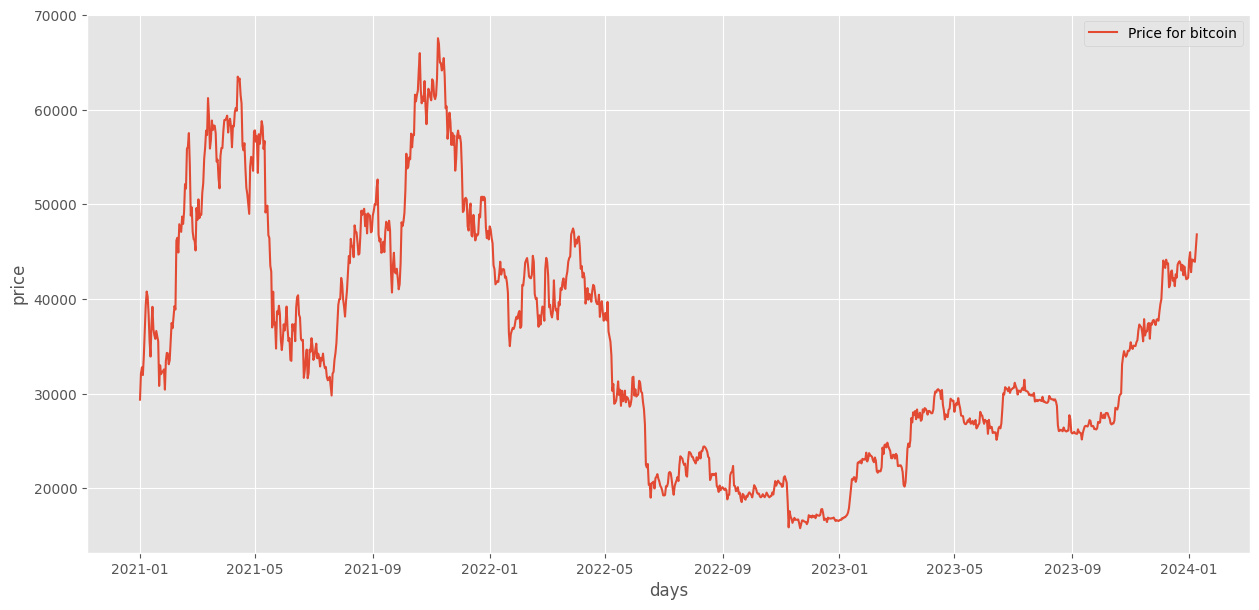

In [51]:
plt.style.use(style = 'ggplot')
plt.figure(figsize=(15,7))
plt.plot(data['close'])
plt.xlabel('days')
plt.ylabel('price')
plt.legend(['Price for bitcoin'])
plt.show()

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data['close']=scaler.fit_transform(data[['close']])

In [55]:
data.head()

,close,date
Date,,
2021-01-01,0.262398,2021-01-01
2021-01-02,0.315568,2021-01-02
2021-01-03,0.328213,2021-01-03
2021-01-04,0.312568,2021-01-04
2021-01-05,0.351590,2021-01-05


In [58]:
data[['close']].tail(3)

,close
Date,
2024-01-06,0.544654
2024-01-07,0.543763
2024-01-09,0.599663


In [59]:
from collections import deque

In [60]:
def prepareData(days):
  df = data.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(data[['close']].tail(days))
  df.dropna(inplace = True)
  sequence_data = []
  sequences = deque(maxlen = 7)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == 7:
      sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  x,y = [], []
  for seq, target in sequence_data:
    x.append(seq)
    y.append(target)

  x = np.array(x)
  y = np.array(y)

  return df, last_sequence, x, y

In [61]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences= True, input_shape = (7, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences = False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  batch_size = 8
  epochs = 80

  model.compile(loss = 'mean_squared_error', optimizer = 'adam')

  model.fit(x_train, y_train,
            batch_size = batch_size,
            epochs = epochs,
            verbose = 1)

  model.summary()


  return model

In [63]:
from multiprocessing.spawn import prepare
predictions = []

lookup_steps = [1,2,3]

for step in lookup_steps:
  df, last_sequence, x_train, y_train = prepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-7:]
  last_sequence = np.expand_dims(last_sequence, axis = 0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
137/137 [==============================] - 15s 27ms/step - loss: 0.0116
Epoch 2/80
137/137 [==============================] - 3s 21ms/step - loss: 0.0041
Epoch 3/80
137/137 [==============================] - 2s 16ms/step - loss: 0.0039
Epoch 4/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0032
Epoch 5/80
137/137 [==============================] - 2s 12ms/step - loss: 0.0025
Epoch 6/80
137/137 [==============================] - 2s 16ms/step - loss: 0.0028
Epoch 7/80
137/137 [==============================] - 2s 14ms/step - loss: 0.0026
Epoch 8/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0024
Epoch 9/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0022
Epoch 10/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0022
Epoch 11/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0018
Epoch 12/80
137/137 [==============================] - 2s 11ms/step - loss: 0.0019
Epoch 13/80


In [73]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d) + '$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'upcoming prediction for upcoming 3 days ({predictions_str})'

print(message)

upcoming prediction for upcoming 3 days (47422.74$, 46503.12$, 45812.12$)
